In [1]:
# import stuff
import numpy as np
import pandas as pd
import uproot as ur
import math
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [2]:
##############################
## Start of defining functions

# get indices of leading values
def leadInd(_array):
    indLead = []
    for x in _array:
        if(len(x)>1):
            indLead.append(np.where(x==max(x)))
        else:
            indLead.append(0) # add an index of zero to the array bc it'll be irrelevant later anyway
    return indLead

# get leading values of jagged array from array of leading indices
def leadVals(_array,_indexArray):
    arrLead = []
    ifCount = 0
    elseCount = 0
    i = 0
    for x in _array:
        if(len(x)>1):
            ifCount +=1
            arrLead.append(x[_indexArray[i][0]])
            i+=1
        else: 
            elseCount +=1
            arrLead.append(x)
            i+=1
    return arrLead

# return array of tuples of Ptx and Pty
def ptXY(_ptArr, _phiArr):
    compArr = []
    i = 0
    for j in _ptArr:
        pt = j
        phi = _phiArr[i]
        ptx = np.cos(phi)*pt
        pty = np.sin(phi)*pt
        i+=1
        compArr.append((ptx,pty))
    return compArr
 
# find pz from pt and eta
def pzPtEta(_pt, _eta):
    pz = _pt*np.sinh(_eta)
    return pz

# get array of (x, y, z) tuples from xyComps and pzArr
def ptXYZ(_ptArr, _phiArr, _etaArr): #where _xyComps is an array of (x, y) tuples
    # make array of tuples (px, py, pz)
    compArr = []
    for pt, phi, eta in zip(_ptArr, _phiArr, _etaArr):
        px = np.cos(phi)*pt
        py = np.sin(phi)*pt
        pz = pzPtEta(pt, eta)
        compArr.append((px, py, pz)) # for some reason each element of this tupe is an array of length 1
    return compArr

#  get the magnitude of a vector from its components
def vMag(_x, _y, _z):
    vm = np.sqrt((_x**2)+(_y**2)+(_z**2))
    return vm

# get momentum from array of three-tuples of components
def pVals(_xyzCompArray):
    pArr = []
    for e in _xyzCompArray:
        p = vMag(e[0], e[1], e[2]) 
        pArr.append(p)
    return pArr

# get leg of a right triangle
def findLeg(_hypotenuse, _otherLeg): # now it's the pythagorean theorem and widely applicable haha
    if(_otherLeg > _hypotenuse):
        return (-1)
    else:
        l2 = np.sqrt((_hypotenuse**2)-(_otherLeg**2))
        return l2

# find mass array from arrays of energy and momentum and also hot encoded isMuon value
def findMass(_eArr, _pArr, _isMuonArr):
    massArr = []
    for e, p, im in zip(_eArr, _pArr, _isMuonArr):
        m = (findLeg(e, p), im)
        if (np.isnan(findLeg(e,p))):
            m = (-1, im) # -1 to indicate that it's a nan value
        if(im==1 or im==0): # if the isMuon value isn't null
            massArr.append(m)
    return massArr

# determine if a list contains a nan value
def containsNAN(_list):
    for i in _list:
        if(not all(i)==True):
            return True
    return False

# decides if the lepton is a muon based on its mass
def isMuon(_mass):
    if(_mass > .1):
        return 1
    else:
        return 0

# takes in an array of masses and returns a list counting nan muons 
def nanMassLept(_massArr):
    nanLepts = []
    for m in _massArr:
        if(m == (-1, 0)):
            nanLepts.append(0) # the null is an electron
        elif(m == (-1, 1)):
            nanLepts.append(1) # the null is a muon
    return nanLepts


## - testEE things that are tested to be electrons and actually are (true negative)
## - testEM things that are tested to be electrons and are actually muons (false negative)
## - testMM things that are tested to be muons and actually are (true positive)
## - testME that are tested to be muons and are actually electrons (false positive)


# gets false positive rate
def falsePositiveRate(_falsePos, _truePos):
    rate = _falsePos/_truePos
    return (rate)


def testEfficiency(_trueTestPos, _truePos):
    return _trueTestPos/_truePos

## End of defining functions
############################

In [3]:
########################
## Start of data pruning

# get tree
file = ur.open("small_v2.root")
file.allkeys()

# get branch
tree = ur.open("small_v2.root")["worldTree"]
tree.allkeys()

# get branches as arrays
leptPt = ur.open("small_v2.root")["worldTree"]["eve.lepton_pt_"]
leptEta = ur.open("small_v2.root")["worldTree"]["eve.lepton_eta_"]
leptPhi = ur.open("small_v2.root")["worldTree"]["eve.lepton_phi_"]
leptE = ur.open("small_v2.root")["worldTree"]["eve.lepton_e_"]
leptIM = ur.open("small_v2.root")["worldTree"]["eve.lepton_isMuon_"]
leptPt = leptPt.array() # for some reason the leadV function freaks when this is done in one line
leptEta = leptEta.array()
leptPhi = leptPhi.array()
leptE = leptE.array()
leptIM = leptIM.array()


# get indices of leading values
leadIs = leadInd(leptPt)
len(leadIs)


# get array of leading values
leadPt = leadVals(leptPt, leadIs)
leadEta = leadVals(leptEta, leadIs)
leadPhi = leadVals(leptPhi, leadIs)
leadE = leadVals(leptE, leadIs)
leadIM = leadVals(leptIM, leadIs)
print("Number of values in each of Pt: ", len(leadPt), ", Eta: ", len(leadEta), ", Phi: ", len(leadPhi), ", E: ", len(leadE), "Lead IM: ", len(leadIM))

## End of data pruning
######################

Number of values in each of Pt:  88850 , Eta:  88850 , Phi:  88850 , E:  88850 Lead IM:  88850


In [4]:
############################
## Start of finding momentum 


# get array of types of ptx and pty
xyComps = []
xyComps = ptXY(leadPt, leadPhi)
print("number of (x,y) tuples: ", len(xyComps))

# # print (x,y)
# for i in range(5):
#     print(xyComps[i])

# create array of three-tuples of (x,y,z)
xyzPComps = []
xyzPComps = ptXYZ(leadPt, leadPhi, leadEta)
print("xyzPComps element structure",xyzPComps[0]) # shows each element of xyzPComps is three-tuple of arrays of length 1

# print("THE FOLLOWING IS RIGHT IF THE X AND Y VALUES MATCH THE ONES FROM ptXY!!")
# # print (x,y,z)
# for i in range(5):
#     print(xyzPComps[i])

print(vMag(xyzPComps[0][0][0],xyzPComps[0][1][0], xyzPComps[0][2][0])) # first element, xyz, get the value of array of length 1

leadP = []
leadP = pVals(xyzPComps)

## End of finding momentum 
##########################

number of (x,y) tuples:  88850
xyzPComps element structure (array([-19.5172343]), array([65.36079359]), array([42.07567028]))
80.14560376073372


In [16]:
########################
## Start of finding mass

/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:86: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


length of leadM:  79102
leadM contains nan:  True
134


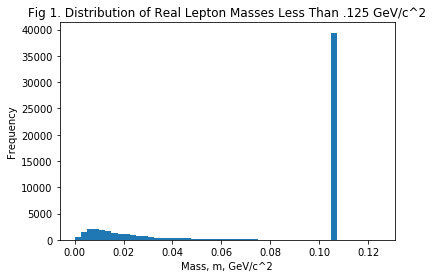

In [5]:
leadM = []
leadM = findMass(leadE, leadP, leadIM)

# for i in range(5):
#     print(leadM[i])

print("length of leadM: ", len(leadM))
print("leadM contains nan: ", containsNAN(leadM))

plotMass = []
for i in leadM:
    if(i[0]>0):
        plotMass.append(i[0][0])
    else:
        plotMass.append(-1)

constrainedPlotMass = []
plotHugeCount = 0
for i in plotMass:
    if(i>0) and i<(0.125):
        constrainedPlotMass.append(i)
    if(i>.125):
        plotHugeCount = plotHugeCount+1

print(plotHugeCount)

plt.hist(constrainedPlotMass, bins=50)
plt.title("Fig 1. Distribution of Real Lepton Masses Less Than .125 GeV/c^2")
plt.xlabel("Mass, m, GeV/c^2")
plt.ylabel("Frequency")
plt.show()

In [6]:

# amount of electrons vs muons
eAnna = [] # electrons as determined by anna
mAnna = [] # muons as determined by anna
nanAnna = 0 # nan as determined by anna


for i in leadM:
    if(isMuon(i[0])==1):
        mAnna.append(i)
    elif(isMuon(i[0])==0):
        eAnna.append(i)
    else:
        nanAnna = nanAnna+1

sElectrons = 0 # number of electrons as determined by small_v2
sMuons = 0 # number of muons as determined by small_v2
sNotMuon = 0
sNoIM = 0
print("LEAD IM LENGTH:", len(leadIM))
for i in leadIM:
    if(i==1):
        sMuons = sMuons + 1
    elif(i==0):
        sElectrons = sElectrons + 1
        sNotMuon = sNotMuon +1
    else:
        sNotMuon = sNotMuon +1
        sNoIM = sNoIM +1

print("SMALL_V2 ISMUON VALUES ET ALIA")
print(" - Muon count:", sMuons)
print(" - Not muon count:", sNotMuon)
print(" - Electron count:", sElectrons)
print(" - No isMuon value count:", sNoIM)
print(" - Lepton count:", (sMuons + sElectrons))

nanLepts = []
nanLepts = nanMassLept(leadM)

nanMuonsCount = sum(nanLepts) # true positives
nanElectronsCount = len(nanLepts)-sum(nanLepts) # true negatives

aMuons = len(mAnna) # test positives
aElectrons = len(eAnna) # test negatives
# print("AS IDENTIFIED BY ANNA: Number of muons-", aMuons, ". Number of electrons-", aElectrons)
# print("AS IDENTIFIED BY ANNA: Number of nan:", nanAnna)
# print("AS IDENTIFIED BY small_v2: Number of muons-", sMuons, ". Number of electrons-", sElectrons)
# print("AS IDENTIFIED BY small_v2: Number of nan muons-", nanMuonsCount, ". Number of nan electrons-", nanElectronsCount )
# print("total leptons (from small_v2):",sMuons + sElectrons)
# print("total leptons, nan or otherwise (from anna):", nanAnna + aMuons + aElectrons)
# print("NAN MUONS !!!!!!: ", nanMuonsCount) #nan values with isMuon=1 hot encoding

print("NaN LEPTS:", len(nanLepts))
print("Anna's electron count not including nan values", aElectrons - len(nanLepts))
aElectrons = aElectrons + nanAnna #Anna has decided all nan mass values are electrons YEET
print("Anna's electron count including nan values (also Anna's test negative)", aElectrons)
print("Anna's muon count:", len(mAnna))
print("small_v2's electron count", sElectrons)



print("number of values in plotmass:", len(plotMass))


LEAD IM LENGTH: 88850
SMALL_V2 ISMUON VALUES ET ALIA
 - Muon count: 39381
 - Not muon count: 49469
 - Electron count: 39721
 - No isMuon value count: 9748
 - Lepton count: 79102


/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/annacuddeback/LHCResearch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


NaN LEPTS: 19771
Anna's electron count not including nan values 19644
Anna's electron count including nan values (also Anna's test negative) 39415
Anna's muon count: 39687
small_v2's electron count 39721
number of values in plotmass: 79102


In [7]:

# count number of true & false positives and true & false negatives
## testEE things that are tested to be electrons and actually are (true negative)
testEE = 0
## testEM things that are tested to be electrons and are actually muons (false negative)
testEM = 0
## testMM things that are tested to be muons and actually are (true positive)
testMM = 0
## testME that are tested to be muons and are actually electrons (false positive)
testME = 0

# print("LEAD M AND LEAD IM FORMAT HERE!!!!! mass:", leadM[0][0],"isMuon:", leadM[0][1])

noLeptonsCount = 0
someOtherErrorCount = 0

for m in leadM:
    _mass = m[0]
    _heIM = m[1]
    _isMuon = isMuon(_mass)
    if(_isMuon==1): # if a test muon
        if(_heIM==1): # if a true muon
            testMM = testMM+1
        elif(_heIM==0):
            testME = testME+1
        else:
            noLeptonsCount = noLeptonsCount+1
    elif(_isMuon==0):
        if(_heIM==0):
            testEE = testEE+1
        elif(_heIM==1):
            testEM = testEM+1
        else:
            noLeptonsCount = noLeptonsCount+1
    else:
        someOtherErrorCount = someOtherErrorCount+1


        
print("noLeptonsCount:", noLeptonsCount, "noLeptonsCount", noLeptonsCount, "someOtherErrorCount", someOtherErrorCount)
print("testEE:", testEE, "testEM", testEM, "testMM", testMM, "testME", testME)
        
print(" - electron false positives:", falsePositiveRate(testEM, sElectrons))
print(" - electron efficiency:", testEfficiency(testEE, sElectrons))
print(" - muon false positives:", falsePositiveRate(testME, sMuons))
print(" - muon efficiency:", testEfficiency(testMM, sMuons))


noLeptonsCount: 0 noLeptonsCount 0 someOtherErrorCount 0
testEE: 39415 testEM 0 testMM 39381 testME 306
 - electron false positives: 0.0
 - electron efficiency: 0.9922962664585484
 - muon false positives: 0.0077702445341662225
 - muon efficiency: 1.0


In [8]:
hugeMassCount = 0
hugeMassIsMuonCount = 0

for m in leadM:
    if(m[0]>.125):
        hugeMassCount = hugeMassCount+1
        if(m[1]==1):
            hugeMassIsMuonCount = hugeMassIsMuonCount+1

print(" - Number of huge particles:", hugeMassCount)
print(" - Number of huge particles that are muons:", hugeMassIsMuonCount)

muonPlotMass = []
electronPlotMass = []
plotMassNoIMCount = 0
for i in leadM:
    if(i[1]==1): # if it's a muon
        muonPlotMass.append(i[0][0])
    elif(i[1]==0): # if it's an electron
        if(type(i[0])==list):
            _mass = i[0][0]
        else:
            _mass = i[0]
        if(_mass > 0):
            electronPlotMass.append(_mass)
        else:
            electronPlotMass.append(-.1)
    else: plotMassNoIMCount = plotMassNoIMCount+1
    # if(i[0]>0):
    #     if(i[1]==1): # if it's a muon
    #         muonPlotMass.append(i[0][0])
    #     elif(i[1]==0): # if it's an electron
    #         electronPlotMass.append(i[0][0])
    # else:
    #     electronPlotMass.append(-1)

print("plotMassNoIMCount:", plotMassNoIMCount)


 - Number of huge particles: 134
 - Number of huge particles that are muons: 0
plotMassNoIMCount: 0


In [9]:
muonStd = np.std(muonPlotMass)
muonMean = np.mean(muonPlotMass)
print("MUON STATISTICS:")
print(" - Muon standard deviation:", muonStd)
print(" - Muon mean:", muonMean)

MUON STATISTICS:
 - Muon standard deviation: 1.0717140183508723e-05
 - Muon mean: 0.1056970343576764


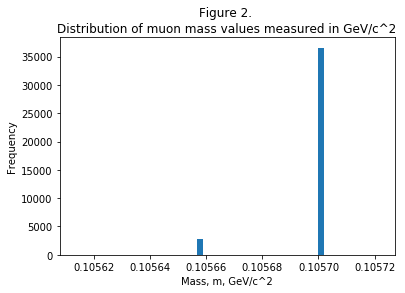

In [12]:

plt.hist(muonPlotMass, bins=50) #not sure why the bin number doens't actually look like 100
plt.title("Figure 2. \nDistribution of muon mass values measured in GeV/c^2")
plt.ylabel("Frequency")
plt.xlabel("Mass, m, GeV/c^2")
blue_patch = mpatches.Patch(color='blue', label='The blue data')
# plt.xlim(left=0, right=0.125)


Text(0.5, 0, 'Mass, m, GeV/c^2')

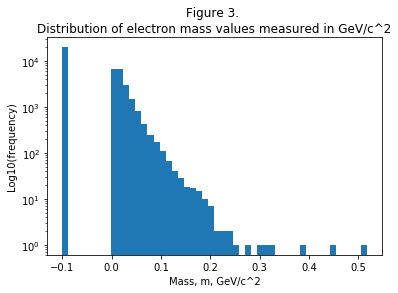

In [14]:
plt.plot
plt.hist(electronPlotMass, bins=50) #not sure why the bin number doens't actually look like 100
plt.yscale("log")
plt.title("Figure 3. \nDistribution of electron mass values measured in GeV/c^2")
plt.ylabel("Log10(frequency)")
plt.xlabel("Mass, m, GeV/c^2")


In [15]:
## End of finding mass
######################